<a href="https://colab.research.google.com/github/Udaychandra44/Devops/blob/main/Project%20Devops.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

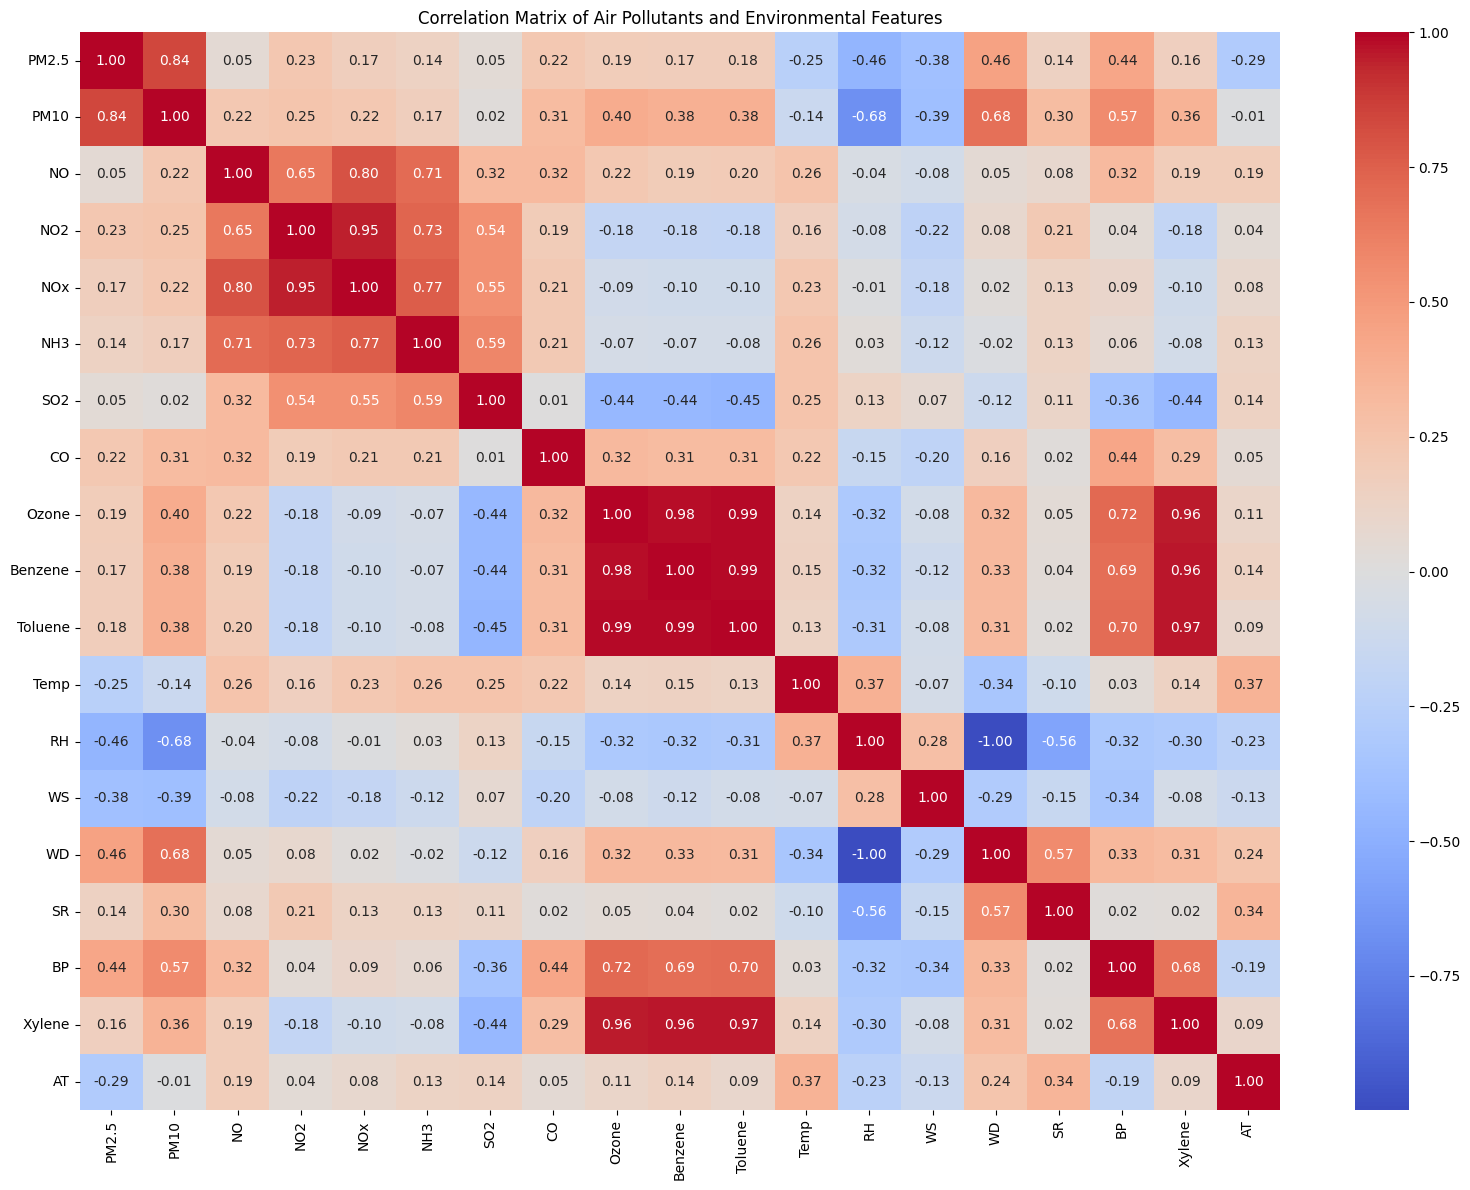

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



--- Federated Learning Round 1 ---
 Training on Client 1
 Training on Client 2
 Training on Client 3

--- Federated Learning Round 2 ---
 Training on Client 1
 Training on Client 2
 Training on Client 3

--- Federated Learning Round 3 ---
 Training on Client 1
 Training on Client 2
 Training on Client 3

--- Federated Learning Round 4 ---
 Training on Client 1
 Training on Client 2
 Training on Client 3

--- Federated Learning Round 5 ---
 Training on Client 1
 Training on Client 2
 Training on Client 3



✅ Final Evaluation — Mean Absolute Error: 19.4118


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
data = pd.read_csv("Data_Air_Pollutant.csv")
data = data.replace("None", np.nan)
data.dropna(inplace=True)
columns_to_convert = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'SO2', 'CO',
                      'Ozone', 'Benzene', 'Toluene', 'Temp', 'RH', 'WS', 'WD',
                      'SR', 'BP', 'Xylene', 'AT']
for col in columns_to_convert:
    data[col] = pd.to_numeric(data[col], errors='coerce')
data.dropna(inplace=True)
plt.figure(figsize=(16, 12))
corr_matrix = data[columns_to_convert].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Air Pollutants and Environmental Features")
plt.tight_layout()
plt.show()
X = data[columns_to_convert]
y = data['PM2.5']  # Target variable
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
client_data = np.array_split(X_scaled, 3)
client_targets = np.array_split(y, 3)
def build_model(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        Dense(32, activation='relu'),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer=Adam(), loss='mse', metrics=['mae'])
    return model

global_model = build_model(X.shape[1])
rounds = 5
epochs = 5
for rnd in range(rounds):
    print(f"\n--- Federated Learning Round {rnd + 1} ---")
    local_weights = []

    for i in range(3):
        print(f" Training on Client {i+1}")
        client_model = clone_model(global_model)
        client_model.set_weights(global_model.get_weights())
        client_model.compile(optimizer=Adam(), loss='mse', metrics=['mae'])
        client_model.fit(client_data[i], client_targets[i], epochs=epochs, verbose=0)
        local_weights.append(client_model.get_weights())
    new_weights = []
    for weights in zip(*local_weights):
        new_weights.append(np.mean(weights, axis=0))
    global_model.set_weights(new_weights)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
loss, mae = global_model.evaluate(X_test, y_test, verbose=0)
print(f"\n✅ Final Evaluation — Mean Absolute Error: {mae:.4f}")
global_model.save("federated_air_quality_model.h5")